## <font color=darkblue> Convolutional neural networks </font>


### <font color=darkred> Bibliography & additional ressources </font>

-  [1] Probabilistic machine learning: an introduction, Kevin P. Murphy, 2022, https://probml.github.io/pml-book/book1.html
``Full book online with all basics on machine learning. Not state-of-the-art but very good introduction``
- [2] Deep learning course, Ms. Sc. Institut Polytechnique de Paris, https://github.com/m2dsupsdlclass/lectures-labs
- [3] Theory of deep convolutional neural networks: Downsampling, 2020,
DX Zhou, Neural Networks.
- [4] A mathematical theory of deep convolutional neural networks for feature extraction,
T Wiatowski, H Bölcskei, 2017, Transactions on Information Theory.
- https://microscope.openai.com/models
- https://poloclub.github.io/cnn-explainer/
- http://alexlenail.me/NN-SVG/index.html
- https://yewtu.be/watch?v=KuXjwB4LzSA 
``Very nice animated explanation of convolutions``

### <font color=darkred>Introduction : general framework & motivations</font>

In machine learning applications to classification, parameter inference often boils down to solving
$$\mathrm{argmin}_{\theta \in \mathbb{R}^d} \,\{\ell_n(\theta)=\frac 1n \sum_{i=1}^n \ell(\theta, y_i, x_i) + \lambda \|\theta\|^2\}\,,
$$
 with $\lambda>0$, where $(x_i,y_i)_{1\leq i\leq n}$ are `training examples of inputs and outputs` (in a supervised setting), $\theta$ is an `unknown parameter to be estimated` and $\ell$ the crossentropy loss (i.e. the negative loglikelihood). 

$$
\ell(\theta, y_i, x_i) = -\sum_{k=1}^M \mathbb{1}_{y_i=k}\log \mathbb{P}_{\theta}(y_i=k|x_i)\,.
$$
The probabilities $\mathbb{P}_{\theta}(y_i=k|x_i)$, $1\leq k \leq M$, can be **modeled using deep learning architectures** which use $x_i$ as input and ouput these probabilities.

In [1]:
import numpy as np
import autograd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import torch

np.set_printoptions(precision=2)
plt.rcParams.update(
    {
        "font.size": 25,
        "figure.figsize": (14, 7),
        "axes.grid": True,
        "grid.color": "#93a1a1",
        "grid.alpha": 0.3,
        "axes.spines.top": False,
        "axes.spines.right": False,
    }
)

### <font color=darkred> Reminder on Feed Forward Neural Networks (from session 2)</font>

The **Multi-layer Perceptron (MLP)** or **Feed Forward Neural Network (FFNN)** weakens the modeling assumptions of the logistic regression and composes in parallel  $L$ perceptron units to produce the output. Let $x\in\mathbb{R}^d$ be the input and define all layers as follows.

\begin{align*}
h_{\theta}^0(x) &= x\,,\\
\mathrm{Linear\; transform}\qquad z_{\theta}^k(x)  &= b^k + W^kh_{\theta}^{k-1}(x)\quad \mathrm{for\;all\;} 1\leqslant k\leqslant L\,,\\
\mathrm{Nonlinear\; transform}\qquad h_{\theta}^k(x)  &= \varphi_k(z_{\theta}^{k}(x))\quad \mathrm{for\;all\;}1\leqslant k\leqslant L\,,
\end{align*}

where for all $1 \leqslant k \leqslant L$, $b^k\in\mathbb{R}^{d_k}$, $W^k\in\mathbb{R}^{d_k\times d_{k-1}}$, with $d_0 \equiv d$, and $\varphi^k: \mathbb{R}^{d_k} \to \mathbb{R}^{d_k}$ is a nonlinear activation function.

Let **$\theta = \{b^1,W^1,\ldots,b^L,W^L\}$ be the unknown parameters of the MLP and $f_{\theta}(x) = h_{\theta}^L(x)$** be the output layer of the MLP.

In a classification setting, **the last activation function is a softmax function so that $f_{\theta}(x)$ contains the probability for each class when the input is $x$**.

![](https://drive.google.com/uc?export=view&id=1STDEPOohPM6RzR2nERWxnmdMzIq9l_TX)
_Illustration of a layer of a dense network_

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
from keras import datasets, layers, models
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import activations
from keras.datasets import cifar10

2023-06-20 11:52:44.502048: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-20 11:52:44.832394: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-20 11:52:47.175735: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### <font color=darkred>Toy dataset of images</font>

CIFAR10 dataset contains 60 000 images of size 32*32 displayed in 10 classes, with 6 000 images in each class:  50 000 images are used as a training set and 10 000 images as a test dataset.

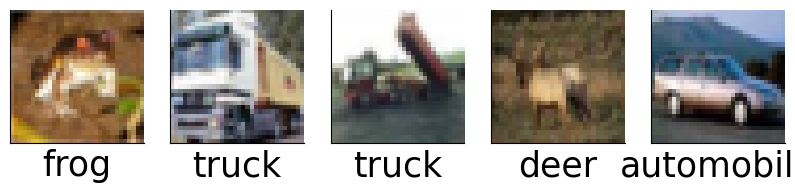

In [44]:
# Load data from the Keras librairy
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0
# Human readable labels
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
# Visualize the dataset
plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

The input size of the data is $32\times 32 \times 3$. This can be used as an input for a MLP in Keras by first **using the [Flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten) layer** which vectorizes each input as a vector of size $d=3072$.

In [50]:
model_ffnn = Sequential()
model_ffnn.add(Flatten(input_shape=(32, 32, 3)))
####
# A compléter
# Ajouter une couche cachée de dimension 16 et de fonction d'activation RELU
####
model_ffnn.add(Dense(16, activation='sigmoid'))
model_ffnn.add(Dense(10))

How many parameters have to be trained in this model ?

**A compléter**

The input dimension is $3072$.
The first layer has dimension $16$, this yields $(3072+1)*16 = 49168$ parameters.
The output layer has dimension 10, this yields $(16+1)*10 = 170$ parameters.

The model has therefore $49338$ parameters.

In [51]:
model_ffnn.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 3072)              0         
                                                                 
 dense_13 (Dense)            (None, 16)                49168     
                                                                 
 dense_14 (Dense)            (None, 10)                170       
                                                                 
Total params: 49,338
Trainable params: 49,338
Non-trainable params: 0
_________________________________________________________________


In [52]:
model_ffnn.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

history = model_ffnn.fit(
    train_images,
    train_labels,
    epochs=15,
    validation_data=(test_images, test_labels)
)

Epoch 1/15
1563/1563 [==============================] - 2s 1ms/step - loss: 1.9663 - accuracy: 0.2955 - val_loss: 1.8402 - val_accuracy: 0.3460
Epoch 2/15
1563/1563 [==============================] - 2s 1ms/step - loss: 1.8176 - accuracy: 0.3558 - val_loss: 1.7737 - val_accuracy: 0.3728
Epoch 3/15
1563/1563 [==============================] - 2s 1ms/step - loss: 1.7698 - accuracy: 0.3758 - val_loss: 1.7527 - val_accuracy: 0.3740
Epoch 4/15
1563/1563 [==============================] - 2s 1ms/step - loss: 1.7431 - accuracy: 0.3826 - val_loss: 1.7382 - val_accuracy: 0.3824
Epoch 5/15
1563/1563 [==============================] - 2s 1ms/step - loss: 1.7218 - accuracy: 0.3883 - val_loss: 1.7477 - val_accuracy: 0.3725
Epoch 6/15
1563/1563 [==============================] - 2s 1ms/step - loss: 1.7037 - accuracy: 0.3972 - val_loss: 1.7103 - val_accuracy: 0.3872
Epoch 7/15
1563/1563 [==============================] - 2s 1ms/step - loss: 1.6895 - accuracy: 0.3996 - val_loss: 1.7199 - val_accuracy:

Plot the accuracy throughout the training

313/313 - 0s - loss: 1.7009 - accuracy: 0.3900 - 176ms/epoch - 562us/step


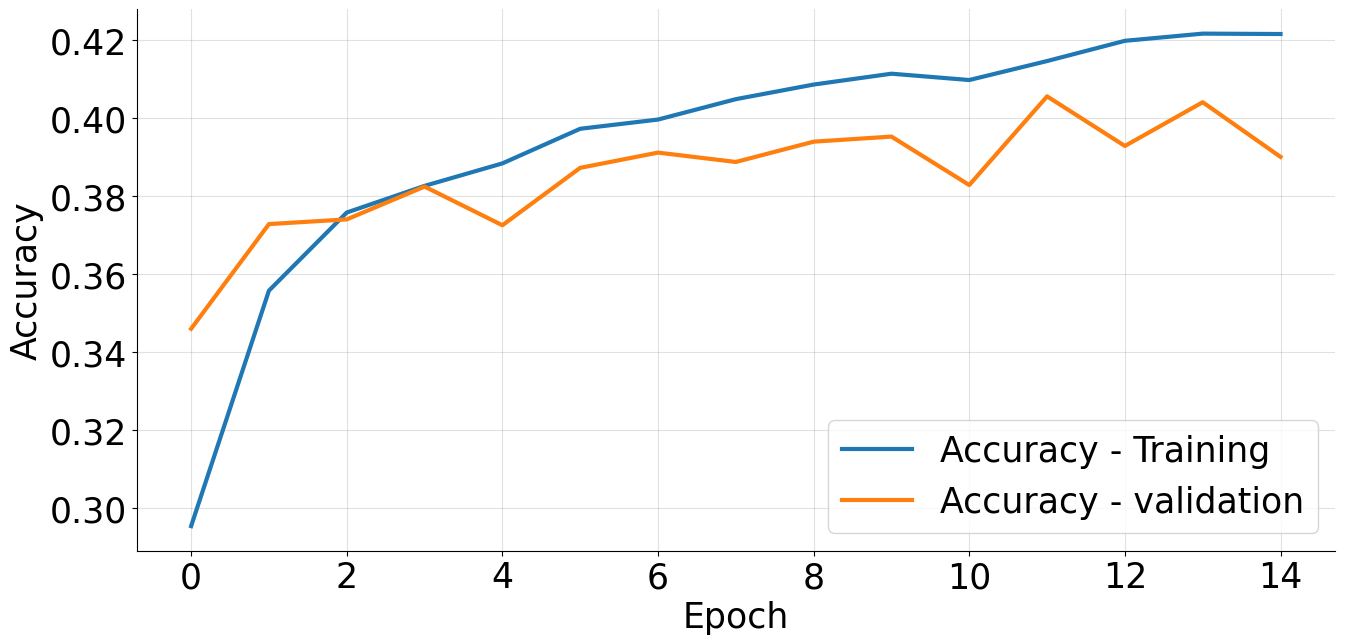

In [53]:
plt.plot(history.history['accuracy'], lw=3, label='Accuracy - Training')
plt.plot(history.history['val_accuracy'], lw=3, label = 'Accuracy - validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.tight_layout();
test_loss, test_acc = model_ffnn.evaluate(test_images,  test_labels, verbose=2)

In [54]:
def display_predictions(dataset_images, dataset_labels, model, class_names, num_images=5): 
    # Sample images from the test set
    subset_indices = np.random.randint(len(dataset_images), size=num_images)
    images_subset = dataset_images[subset_indices]
    # Run a prediction with the model
    netout = model.predict(images_subset[:5])
    predictions = [class_names[idx] for idx in netout.argmax(-1)]
    labels = [class_names[idx] for idx in dataset_labels[subset_indices].squeeze()]
    # Display images
    fig, axes = plt.subplots(nrows=1, ncols=num_images)
    for ax, image, label, prediction in zip(axes, images_subset, labels, predictions):
        ax.imshow(image)
        ax.set_title(f"{prediction} ({label})", fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])

Display predictions of the model agains the ground truth label (in parenthesis) on five samples of the test set

1/1 [==============================] - 0s 25ms/step


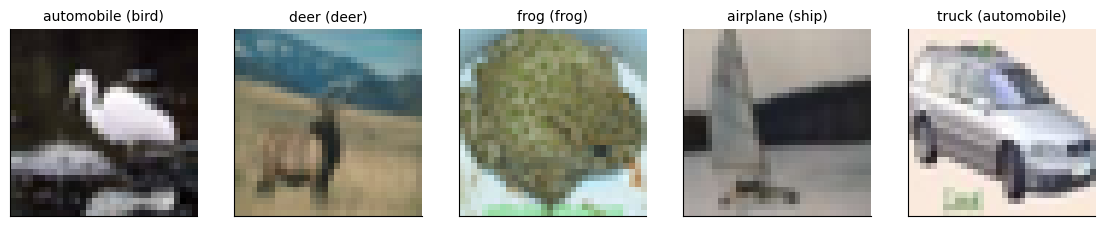

In [55]:
display_predictions(test_images, test_labels, model=model_ffnn, class_names=class_names)

### <font color=darkred> Convolutional Neural Networks </font>

In practice, increasing the size of hidden layers is not effective and **adding more layers** is an appealing alternative. This can be interpreted as a way to learn several latent states corresponding to **different features** contained in the input data.  For example, in object detection tasks, it is easier to express shapes from edges and objects from shapes, than to express objects from pixels.

When several inputs might contain the same kind of information, **sharing their associated weights/parameters** is a way to **learn statistically invariant properties**.
Using this concept on images leads to convolutional neural networks (CNNs), and on time series this leads to recurrent neural networks (RNNs).  When using CNNs, weights are set to a small kernel that is used to perform a convolution across images.

**We first get rid of the `Flatten` step which vectorized the input and use multidimentsional convolutions to exploit the structure of the input data**.

#### **Convolutions**

If $f$ and $g$ are two real-valued functions, their convolution is defined by
$$
f*g:t\mapsto \int_{\mathbb{R}} f(\tau)g(t-\tau)\mathrm{d}\tau\,.
$$

Illustration from Wikipedia:

![](https://en.wikipedia.org/wiki/Convolution#/media/File:Convolution_of_spiky_function_with_box2.gif)


In the FFNN case, the step ``model_ffnn.add(Flatten(input_shape=(32, 32, 3)))`` destroys the spatial organization of the input but is mandatory before the fully connected step: `model_ffnn.add(Dense(16, activation='relu'))`. The spatial organization of the input may be preserved before using Flatten by convolution steps such as ``model_cnn.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))``. This layer has 32 outputs, each of which depending on a 3*3 weight matrix.

##### **Elementary algebra**

A *Filter (or kernel)* is a two-dimensional matrix of size $K\times K$.


Let $I$ be the input matrix and $O$ be the output matrix. Mathematically, the convolution operation is
$$
O(i,j) = I\odot\Omega(i,j)=  \sum_{m=1}^K\sum_{\ell=1}^K\Omega(m,\ell)I(i-1+m,j-1+\ell)\,,
$$
where $\Omega$ is the matrix of weights/parameters of the kernel.

The convolution is computed by **sliding the filter over the image, starting from the top
left corne0r**. Then, the first value of the output matrix is obtained by summing the product of the
corresponding pixel value and the filter value. Similarly, the final output is computed by moving the filter from left to right and from top to bottom.

Consider the edge detection kernel
$$
\Omega = \begin{pmatrix}
0 & -1 & 0 \\
-1 & 4 & -1 \\
0 & -1 & 0
\end{pmatrix}
$$
Apply this kernel to the input matrix
$$
I = \begin{pmatrix}
0 & 0 & 0 & 0\\
0 & 1 & 1 & 0 \\
0 & 1 & 1 & 0 \\
0 & 0 & 0 & 0
\end{pmatrix}
$$
Compute the convolution between $I$ and $\Omega$.

**A compléter**

Applying $\Omega$ from left to right and top to bottom yields
\begin{align*}
I\odot \Omega(1,1) &= 0\times 0 -1\times 0 + 0\times 0 -1\times 0 + 4\times 1 - 1\times 1 + 0\times 0 - 1\times 1 + 0\times 1 = 2\,,\\
I\odot \Omega(1,2) &= 0\times 0 -1\times 0 + 0\times 0 -1\times 1 + 4\times 1 - 1\times 0 + 0\times 1 - 1\times 1 + 0\times 0 = 2\,,\\
I\odot \Omega(2,1) &= 0\times 0 -1\times 1 + 0\times 1 -1\times 0 + 4\times 1 - 1\times 1 + 0\times 0 - 1\times 0 + 0\times 1 = 2\,,\\
I\odot \Omega(2,2) &= 0\times 1 -1\times 1 + 0\times 0 -1\times 1 + 4\times 1 - 1\times 0 + 0\times 0 - 1\times 0 + 0\times 1 = 2\,,
\end{align*}
so that
$$
I\odot \Omega = \begin{pmatrix}
2 & 2\\
2 & 2
\end{pmatrix}
$$

![](https://kionkim.github.io/assets/no_padding_no_strides.gif)

_Convolution with a $3 \times 3$ kernel_

**Padding & stride**

The outer pixel values are only involved once in one of the operations, whereas the inner pixel values are involved multiple times.

Compared to the original image, the dimension of the output feature map has been reduced. In the above example, the original image has size 4 × 4, while the output has size only 2 × 2.

**Padding**  can be used by adding 0 values around the input images before applying the convolution. If a padding of size $p$ is used on an input image of size $n\times d$, the resulting matrix has size $(n+2p)\times(d+2p)$.

The **stride** is the distance between each
movement of the kernel, it indicates how many pixels the kernel is shifted over at each step. In general, the stride value for the convolutional layer is 1.

![](https://kionkim.github.io/assets/no_padding_2_strides.gif)

_Convolution with a stride of 2_

![](https://kionkim.github.io/assets/same_padding_no_strides.gif)

_Convolution with added padding. This value of the padding is chosen to keep the same dimension between input and output. For a kernel of size $k=3$, we chose $p = \lfloor k / 2 \rfloor = 1$._

In summary, performing the convolution between the image and the kernel consists in moving the kernel across the image, and to produce an output for each patch. The way you move across the image is defined by two parameters:

- `Stride`: the stride is the number of pixels you are shifting each time you move your kernel during the convolution.
- `Padding`: defines what happens when the kernel reaches a border of the image when doing the convolution.
"Valid" padding means that you stop at the edge, while "Same" padding allows to go off the edge and pad with zeros so that the width and the height of the output and input tensors are the same.

A very nice interactive illustration of convolutions, padding and stride: https://poloclub.github.io/cnn-explainer/

##### **Max Pooling and Average pooling**

A common way to share information (i.e. share parameters) in a neighborhood of the image is to use pooling. Max Pooling computes the maximum value of the part of the image covered by the kernel. Average Pooling computes the average of the values of the image covered by the Kernel.

In [10]:
def max_pool(X,q):
    n, p = X.shape
    A = X.reshape(n//q,q,p//q,q)
    B = A.transpose((0, 2, 1, 3))
    X_transformed = B.max(axis=(2,3))
    return X_transformed

In [11]:
X = np.array([[1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11, 12],[13, 14, 15, 16]])
q = 2
print(X)

[[ 1  2  3  4]
 [ 5  6  7  8]
 [ 9 10 11 12]
 [13 14 15 16]]


In [12]:
max_pool_X = max_pool(X,2)
max_pool_X

array([[ 6,  8],
       [14, 16]])

In [13]:
def average_pool(X,q):
    n, p = X.shape
    A = X.reshape(n//q,q,p//q,q)
    B = A.transpose((0, 2, 1, 3))
    X_transformed = B.mean(axis=(2,3))
    return X_transformed

In [14]:
average_pool_X = average_pool(X,2)
average_pool_X

array([[ 3.5,  5.5],
       [11.5, 13.5]])

![](https://nico-curti.github.io/NumPyNet/NumPyNet/images/maxpool.gif)

_Max pooling in action_

#### **A few specific kernels**

In [15]:
from skimage.io import imread, imshow
from skimage.color import rgb2gray
from skimage.transform import rescale
from scipy.signal import convolve2d

def plot_image(image, **kwargs):
    plt.imshow(image, **kwargs)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

Our sample image

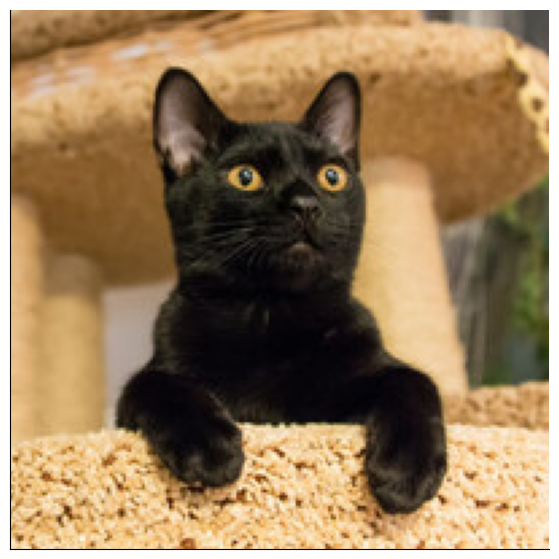

In [16]:
X = plt.imread("test_kernel.jpg") / 255
plot_image(X)

**Edge detection**

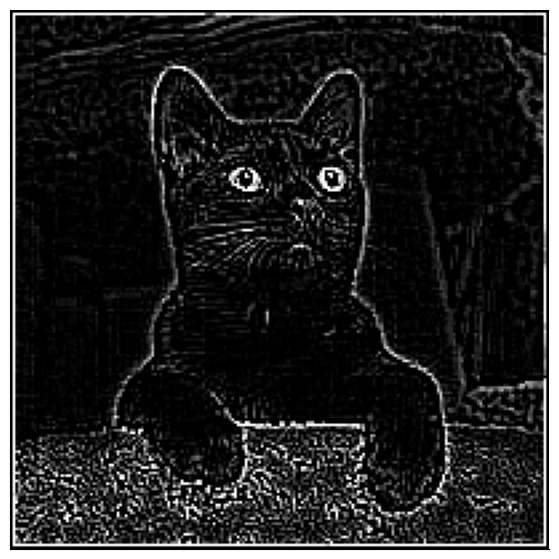

In [17]:
edge_kernel = np.array([[-1, -1, -1],
                        [-1, 8, -1],
                        [-1, -1, -1]])
conv_im = convolve2d(X[:,:, 0], edge_kernel[::-1, ::-1]).clip(0,1)
plot_image(conv_im, cmap='gray')

**Blurring kernels**

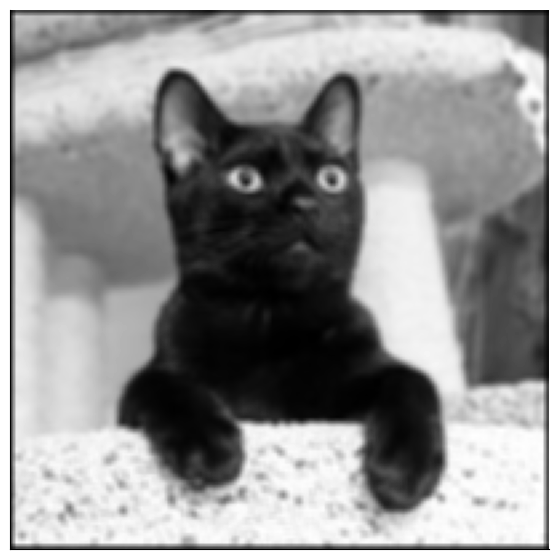

In [18]:
blur_kernel = np.array([[1/9, 1/9, 1/9],
                        [1/9, 1/9, 1/9],
                        [1/9, 1/9, 1/9]])
# Also try the `gauss_kernel` for improved mathematical justification
gauss_kernel = np.array([[1/16, 1/8, 1/16],
                         [1/8, 1/4, 1/8],
                         [1/16, 1/8, 1/16]])

conv_im = convolve2d(X[:,:,0], blur_kernel[::-1, ::-1]).clip(0,1)
plot_image(conv_im, cmap='gray');

#### **Convolution layers**

Each output neuron of the next layer is computed as follows (image taken from https://adventuresinmachinelearning.com/convolutional-neural-networks-tutorial-tensorflow/) before computing an elementwise RELU function:

![](https://drive.google.com/uc?export=view&id=18Y0RuvolJcivNRuC0gKpzLubQhy889Tu)

The convolution maps patches of the input image, combined with the convolution kernel, for example
$$
\text{output} = \text{ReLU}(\text{patch} \times W + b)\,.
$$

A classical approach is to use a stride of 1 and to combine theoutputs being in some neighborhood. Such an operation combining elements of a tensor is called ``pooling``: ``model_cnn.add(MaxPooling2D(pool_size=(2, 2)))``. Neighborhoods are define by the pooling window dimension (width x height) and the strides you use when moving this window across the image.  Again, a sliding window is applied along the input to produce the output, the most common function applied on each window being the ma function: it aggregates several outputs in a neighborhood $N$ using a max operation:
$$
\text{output}'_i = \max_{j \in N}\text{output}_j, \quad i \in N.
$$
The formulas to compute the size of the ouput tensor are the same as for convolution padding and striding: (image taken from https://adventuresinmachinelearning.com/convolutional-neural-networks-tutorial-tensorflow/):

![](https://drive.google.com/uc?export=view&id=1Skpk6gyNmLMuySvaSk9KoJ_Vl_I7oT6X)

#### **Example CNN**

In [19]:
model = models.Sequential()
####
# A compléter
# Ajouter une couche Conv2D de dimension 32 avec un noyau de taille 3x3.
####
model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(10))

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          18496     
                                                                 
 flatten_1 (Flatten)         (None, 1024)             

In [21]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=15,
                    validation_data=(test_images, test_labels))

Epoch 1/15
1563/1563 [==============================] - 23s 14ms/step - loss: 1.5559 - accuracy: 0.4377 - val_loss: 1.3250 - val_accuracy: 0.5270
Epoch 2/15
1563/1563 [==============================] - 24s 15ms/step - loss: 1.2306 - accuracy: 0.5636 - val_loss: 1.1785 - val_accuracy: 0.5864
Epoch 3/15
1563/1563 [==============================] - 22s 14ms/step - loss: 1.0990 - accuracy: 0.6141 - val_loss: 1.1482 - val_accuracy: 0.5926
Epoch 4/15
1563/1563 [==============================] - 21s 13ms/step - loss: 1.0094 - accuracy: 0.6488 - val_loss: 1.0118 - val_accuracy: 0.6483
Epoch 5/15
1563/1563 [==============================] - 23s 15ms/step - loss: 0.9447 - accuracy: 0.6701 - val_loss: 0.9783 - val_accuracy: 0.6589
Epoch 6/15
1563/1563 [==============================] - 22s 14ms/step - loss: 0.8959 - accuracy: 0.6887 - val_loss: 0.9506 - val_accuracy: 0.6678
Epoch 7/15
1563/1563 [==============================] - 20s 13ms/step - loss: 0.8520 - accuracy: 0.7040 - val_loss: 0.9778 -

313/313 - 0s - loss: 0.9429 - accuracy: 0.6890 - 465ms/epoch - 1ms/step


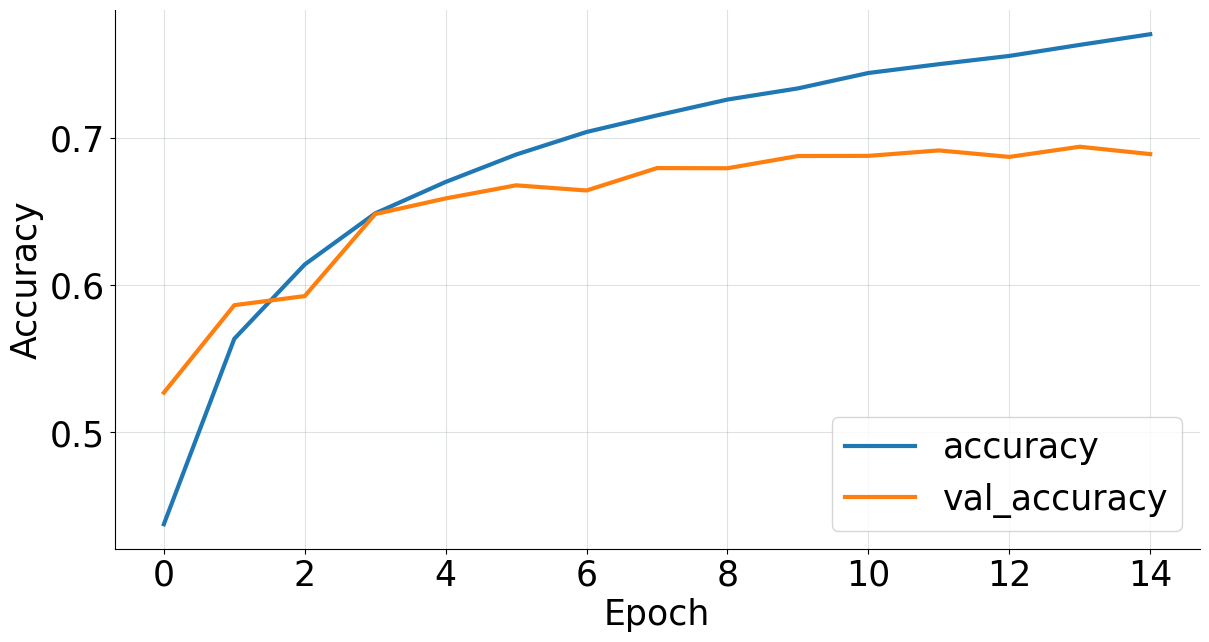

In [22]:
plt.plot(history.history['accuracy'], lw=3, label='accuracy')
plt.plot(history.history['val_accuracy'], lw=3, label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

1/1 [==============================] - 0s 13ms/step


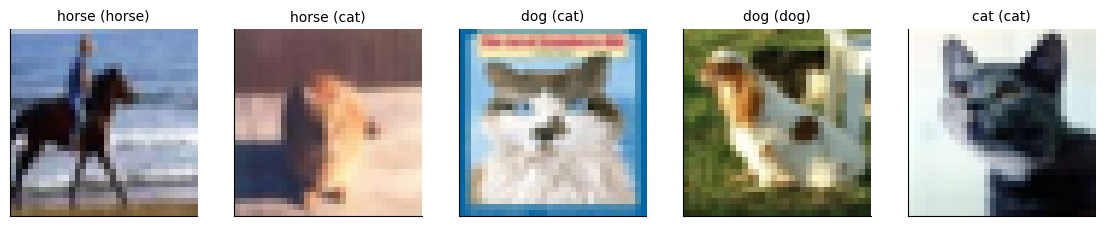

In [25]:
display_predictions(test_images, test_labels, model=model, class_names=class_names)

### <font color=darkred> Theory of Convolutional Neural Networks: downsampling and feature extraction </font>

Convolutional neural networks **are widely used to perform feature extraction** and many architectures have been proposed to do so using for instance  **wavelets**, **random kernels** or **trained kernels**.

In [4, Theorem 1], the authors show that deep CNN show a vertical translation invariance i.e. the **extracted features are
more translation-invariant when increasing network depth**.
The translation invariance is shown to be crucially driven by the pooling factors.  **Pooling is necessary to obtain vertical to obtain asymptotic full translation invariance**.

Let $n\in\mathbb{N}^*$ be the number of layers of the network and $\Phi^n(f)$ the features of the input $f$ generated by the $n$-th network layer. If $T_t$ is the translation operator, [4, Theorem 1] provides a control of the form
$$
\|\Phi^n(T_tf)-\Phi^n(f)\| \leq \frac{C}{S_1\ldots S_n}\|f\|\,
$$
where $C$ is a constant and the $S_i$, $1\leq i \leq n$, are the pooling factors.

We may also consider time-frequency deformations such as non-linear distortions of the form $F_{\tau,\omega}f(x) = \mathrm{e}^{
2i\pi \omega(x)}f(x − \tau (x))$. Under mild assumptions on the Jacobian matrix of $\tau$, [4,Theorem 2] shows that
$$
\|\Phi^n(F_{\tau,\omega}f)-\Phi^n(f)\| \leq C_1(C_2 \|\tau\|_\infty + \|\omega\|_\infty)\|f\|\,,
$$
i.e. **minor nonlinear deformations** imply **minor deformations of the feature vector**.

### <font color=darkred> Classical Convolutional Neural Networks </font>

>Classical CNN architectures schematics can be found here: http://alexlenail.me/NN-SVG/index.html



##### **AlexNet**

AlexNet was introduced in 2012 and uses a 8-layer convolutional neural network. It contains five convolution layers, two hidden fully-connected layers and one fully-connected output layer.

 A brief summary of AlexNet is illustrated below, see https://guandi1995.github.io/Classical-CNN-architecture/.

##### **VGG 16**

VGG-16 was introduced in 2014 is a 16-layer network using  multiple 3x3 kernels.  Max pooling layers all use a 2x2 kernel with a stride of 2.

A brief summary of VGG-16 is illustrated below, see https://guandi1995.github.io/Classical-CNN-architecture/.

### <font color=darkred> Interpreting and visualizing deep CNN *architectures* </font>

In [ ]:
# Load and summarize a pre-trained VGG16 model
from keras.applications.vgg16 import VGG16
model = VGG16()
model.summary()

Visualizing VGG16 here: https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/

Collection of visualizations of every significant layer and neuron of classical vision models: https://microscope.openai.com/models

### <font color=darkred> Application to time series </font>

In [ ]:
import tensorflow as tf
import pandas as pd
import datetime
from sklearn.model_selection import GridSearchCV, train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Normalization

In [ ]:
# Download dataset
!wget https://gitlab.com/max.cohen/ateliers-algos/-/raw/main/heating_lilles.csv
df = pd.read_csv('heating_lilles.csv')
df.index = pd.DatetimeIndex(df.datetime) + pd.DateOffset(years=1)
df.sample(5)

In [ ]:
# Select cooling period
selection = df[(df.index < datetime.datetime(2019, 4, 18)) | (df.index >= datetime.datetime(2019, 10, 1))].copy()
# Group the data by day
selection["date"] = selection.index.date
selection = selection.groupby("date").agg({"outdoor_temperature_deg_celsius": list, "heating_kWh": list})
# Split the data between a training and an evaluation set.
X = np.stack(selection.outdoor_temperature_deg_celsius.values)
y = np.stack(selection.heating_kWh.values)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

**Dense Network**

In [ ]:
####
# A compléter
# Implémenter un réseau dense
####
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2))

**Convolutional network**

In [ ]:
####
# A compléter
# Proposer et apprendre un réseau convolutif sur les échantillons d'entraînement en maximisant l'erreur L2
####